## Anatomical organization of the network

In this notebook, we first look at the anatomical distribution of head direction neurons across fish, to assess whether there is anatomical consistency over the anatomical location of cells w/r/t their position in the network activity topology. 

By doing that, we find a unified phase space that replaces the arbitrary orientation of cells in phase space for each fish; by orienting all of them in the same way with respect to the anatomy, we ensure that a given network phase always corresponds to a specific location of activity in the aHB. This rotated phase is what will actually be used in all subsequent analyses.

**TODO**
 - [ ] redefine the centering of the coordinates after morphing is done

In [1]:
%matplotlib widget
from pathlib import Path

import lotr.plotting as pltltr
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment, dataset_folders
from lotr.data_preprocessing.anatomy import anatomical_angle_remapping
from lotr.notebook_utils import print_source
from lotr.pca import pca_and_phase
from lotr.rpca_calculation import get_zero_mean_weights, reorient_pcs
from lotr.utils import get_rot_matrix, get_vect_angle, reduce_to_pi, zscore
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu

COLS = pltltr.COLS

## Is there an anatomical organization?

First, let's see whether the organization of cells in PC space matches their anatomical location.

In [2]:
# Compute PCA in time and angles for each neuron:
exp = LotrExperiment(A_FISH)

pca_scores, angles, _, circle_params = pca_and_phase(
    exp.traces[exp.pca_t_slice, exp.hdn_indexes].T
)

# We will work with the z projection, ignoring depth:
coords = exp.coords_um[exp.hdn_indexes, 1:]

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
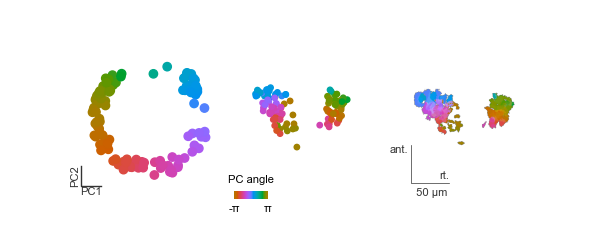

In [3]:
# Now plot phase over the anatomy:
f, axs = plt.subplots(1, 3, figsize=(6, 2.5))

axs[0].scatter(pca_scores[:, 0], pca_scores[:, 1], c=angles, cmap=COLS["phase"])
pltltr.add_scalebar(axs[0], xlabel="PC1", ylabel="PC2", xlen=30, ylen=30)
axs[0].axis("equal")

# Show coordinates:
sc = axs[1].scatter(coords[:, 0], coords[:, 1], c=angles, cmap=COLS["phase"], s=15)

axs[1].set(xlim=exp.lr_extent_um, ylim=exp.pa_extent_um)
axs[1].axis("off")
pltltr.add_cbar(
    sc,
    axs[1],
    inset_loc=(-0.0, 0.15, 0.25, 0.04),
    ticks=[-np.pi + 0.1, np.pi - 0.1],
    ticklabels=["-π", "π"],
    title="PC angle",
    titlesize=8,
    orientation="horizontal",
)

# Show ROI map:
colored_rois = exp.color_rois_by(angles, color_scheme=COLS["phase"])
axs[2].imshow(colored_rois.max(0), extent=exp.plane_ext_um, origin="lower")
pltltr.add_anatomy_scalebar(axs[2])

pltltr.savefig("anatomical_distribution_onefish")

Yay! There seems to be an interesting anatomical localization, as expected from the raw activity after bouts.

## Rotate PC space to match anatomy

Now, if we want to compare anatomical distributions between different fish in the same figure, we need to somehow match the ROI coordinates in PC space from one fish to the other. Lukily, they are arranged in a circle! It should not be too hard to match the phases across fish with the following steps:
 1. Compute PCs across time
 2. Center them to have 0 mean
 3. Find a rotation so that the ROIs on the left of the "rotated PC" (**rPC**) circle (0 phase) are the left ROIs, and the ROIs on top of the PC circle are the rostral ROIs
 4. Define a new "rPC" angle for all neurons in this new space, and a use them to define a phase which is now in the same space across all fish

In [4]:
# 1. compute PCs:
exp = LotrExperiment(A_FISH)
pca_scores, angles, _, circle_params = pca_and_phase(
    exp.traces[exp.pca_t_slice, exp.hdn_indexes].T
)

# 2. center on 0:
centered_pca_scores = pca_scores[:, :2] - circle_params[:2]

### Find PC rotation

Step 3 will be slightly trickier. Our strategy is to find the vector in the circle that points toward the location of frontal-most ROIs. To do so, we will average ROIs angles (vectors) over the circle, similarly to what we did for the network phase, but now weghting for anatomical location over antero-posterior and left-right axes. As weights, we will be using coordinates after an offset subtraction that makes them 0-mean (the function also removes eventual outliers).

In [5]:
# get 0-mean coords (exclude z axis aready from here)
w_coords = get_zero_mean_weights(exp.coords[exp.hdn_indexes, 1:])

# Compute the PCs vector averages across the population using coordinates along
# each anatomical axis as weights.
# The result is a 3 x 2 matrix containing the average vector for each of the
# 3 anatomical axes used as weights:
avg_vects = np.einsum("ij,ik->jk", centered_pca_scores, w_coords)

# get angle from vectors for the 3 anatomical coordinates:
avg_angles = get_vect_angle(avg_vects)

# and we take the mean between left-right and anterior-posterior axes angles:
mean_angle = np.angle(np.sum(np.cos(avg_angles)) + 1j * np.sum(np.sin(avg_angles)))

# Since PC signs can be arbitrary, we also need to find whether left and right
# were flipped. This we decide based on the difference in sign from the angle
# between the lateral and sagittal axes fit in PC space:
s = np.sign(reduce_to_pi(avg_angles[1] - avg_angles[0]))
invert_mat = np.array([[1, 0], [0, s]])

# At this point, we simply need to rotate the coordinates so that the
# mean angle between vector pointing forward and vector pointing rightward is placed
# at (1/4)*pi (angle E):
FINAL_TH_SHIFT = -(1 / 4) * np.pi
#
rotated_pca_scores = (
    get_rot_matrix(FINAL_TH_SHIFT)
    @ get_rot_matrix(-mean_angle * s)
    @ invert_mat
    @ centered_pca_scores.T
).T

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
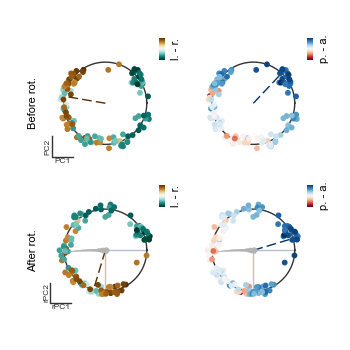

In [6]:
seg_len = 100
col_schemes = ["BrBG_r", "RdBu"]
f, axs = plt.subplots(2, 2, figsize=(3.5, 3.5))

radius = np.max(circle_params[2])

for i, coords in enumerate([centered_pca_scores, rotated_pca_scores]):
    for j, col in enumerate(col_schemes):
        ax = axs[i, j]
        sc = ax.scatter(
            coords[:, 0],
            coords[:, 1],
            c=exp.coords[exp.hdn_indexes, j + 1],
            cmap=col,
            s=10,
        )
        ax.plot(*pltltr.get_circle_xy((0, 0, radius)), lw=1, c=".2", zorder=-100)

        line_col = cm.get_cmap(col).get_over()  # get line color from cmap

        avg_vects = np.einsum("ij,ik->jk", coords, w_coords)
        # get angle from vectors for the 3 anatomical coordinates:
        avg_angles = get_vect_angle(avg_vects)

        ax.plot(
            [0, np.cos(avg_angles[j]) * radius],
            [0, np.sin(avg_angles[j]) * radius],
            lw=1.0,
            ls="--",
            dashes=(7, 3),
            c=line_col,
        )
        ax_lab = ["l. - r.", "p. - a."][j]
        pltltr.add_cbar(
            sc, ax, (0.98, 0.9, 0.05, 0.18), ticks=[], label=ax_lab, titlesize=9,
        )
        l = 120
        ax.set(xlim=(-l, l), ylim=(-l, l))
        pltltr.despine(ax, "all")

for ax in axs[1, :]:
    for j, col in enumerate(col_schemes):
        l_col = cm.get_cmap(col).get_over()
        ax.plot(
            [0, np.sin(j * np.pi / 2) * radius],
            [0, -np.cos(j * np.pi / 2) * radius],
            c=l_col,
            lw=1.0,
            alpha=0.3,
            zorder=-100,
        )
        pltltr.add_fish(ax, head_offset=(0, 0), c=".7", scale=radius, angle=-np.pi / 2)


axs[0, 0].set(ylabel="Before rot.")
axs[1, 0].set(ylabel="After rot.")
blen = 40
pltltr.add_scalebar(
    axs[0, 0], xlabel="PC1", ylabel="PC2", xlen=blen, ylen=blen, fontsize=6
)
pltltr.add_scalebar(
    axs[1, 0], xlabel="rPC1", ylabel="rPC2", xlen=blen, ylen=blen, fontsize=6
)

pltltr.savefig("anatomical_fit_onefish.pdf")

In the actual analysis, the `reorient_pcs(pcs, coords)` function is used to reorient the PC axes to match anatomy, doing exactly the steps we did above:

In [7]:
reorient_with_funct = reorient_pcs(centered_pca_scores, w_coords)

# Important check that demo and lotr function are consistent:
assert np.allclose(rotated_pca_scores, reorient_with_funct)

### Define convention for rPC angles and phase

We need now a convention to define neuron angles, and therefore network phase. Our definition will be the following:
 - Caudal neurons will have angle 0; network phase 0 will correspond to caudal activity;
 - Angle will **increase mowing clockwise in the anatomy**  and **decrease moving counterclockwise in the anatomy**.
 
Therefore, if there is anatomical organization, starting from the rostral 0:
 - Left neurons will have (mostly) positive angles (if topology is true)
 - Right neurons will have (mostly) negative angles

In [8]:
pca_scores, angles, _, circle_params = pca_and_phase(
    exp.traces[exp.pca_t_slice, exp.hdn_indexes].T
)

In [9]:
# The rotated PCs are already centered on 0, so:
rpc_angles = np.arctan2(rotated_pca_scores[:, 1], -rotated_pca_scores[:, 0])

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
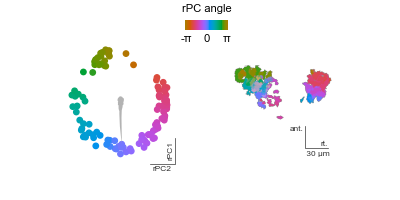

In [10]:
# Now plot phase over the anatomy:
f, axs = plt.subplots(1, 2, figsize=(4, 2.0))

# Inverting scatter order and sign we rotate the plot by 90° so that
# frontal ROIs are on top:
sc = axs[0].scatter(
    -rotated_pca_scores[:, 1],
    rotated_pca_scores[:, 0],
    c=rpc_angles,
    cmap=COLS["phase"],
    vmax=np.pi,
    vmin=-np.pi,
    s=15,
)
pltltr.add_scalebar(
    axs[0],
    xlabel="rPC2",
    ylabel="rPC1",
    xpos=100,
    line_params=dict(lw=0.5),
    xlen=-45,
    ylen=45,
    fontsize=6,
)

l = 130
axs[0].set(xlim=(-l, l), ylim=(-l, l))

pltltr.add_cbar(
    sc,
    axs[0],
    inset_loc=(1, 1, 0.3, 0.06),
    ticks=[-np.pi + 0.1, 0, np.pi - 0.1],
    ticklabels=["-π", "0", "π"],
    title="rPC angle",
    orientation="horizontal",
    titlesize=8,
)
pltltr.add_fish(axs[0], head_offset=(0, 0), c=".7", scale=80, angle=0)

colored_rois = exp.color_rois_by(rpc_angles, color_scheme=COLS["phase"])
axs[1].imshow(
    pltltr.color_zproject(colored_rois, mode="overlay"),
    extent=exp.plane_ext_um,
    origin="lower",
)
pltltr.add_anatomy_scalebar(axs[1], pos=(110, 40), length=30, fontsize=6)

pltltr.savefig("registered_angles_onefish.pdf")

All those operations from now on will be performed under the hood when asking for the experiment attributes `LotrExperiment.rpc_scores` and `LotrExperiment.rpc_angles`.

In [11]:
assert np.allclose(rotated_pca_scores, exp.rpc_scores, rtol=0.001)
assert np.allclose(rpc_angles, exp.rpc_angles, rtol=0.001)

## Registration of all fish on one PC space

Now, we can transform coordinates from all fish so that they are all oriented in the same way w/r/t the anatomy. We could also normalize their radius, but we won't do it here to appreciate better the dispersion of colors around the circle:

In [12]:
results_list = []

np.random.seed(50)

# Loop over all fish, and compute values for data and after shuffling coords itentity:
for path in dataset_folders:
    for group, shuf_f in zip(["data", "shuf"], [lambda x: x, np.random.shuffle]):
        exp = LotrExperiment(path)
        sequence = np.arange(len(exp.hdn_indexes))
        shuf_f(sequence)

        # center coords (will be replaced with morphing):
        coords = exp.coords_um[exp.hdn_indexes, 1:][sequence, :]  # shuffle if necessary
        coords = coords - np.mean(coords, 0)

        # And, for plotting, computing an "anatomical phase", aka position around the anatomy:
        anatomical_phase = np.angle(-coords[:, 1] + 1j * -coords[:, 0])

        # Stretch angle to avoid undersampling aroung midline
        anatomical_phase = anatomical_angle_remapping(anatomical_phase)

        r = np.mean(np.sqrt(exp.rpc_scores[:, 0] ** 2 + exp.rpc_scores[:, 1] ** 2))
        results_list.append(
            pd.DataFrame(
                dict(
                    rpc1_proj=exp.rpc_scores[:, 0] / r,
                    rpc2_proj=exp.rpc_scores[:, 1] / r,
                    lr_pos=coords[:, 0],
                    ap_pos=coords[:, 1],
                    rpc_angle=exp.rpc_angles,
                    anatomical_phase=anatomical_phase,
                    exp_id=path.name,
                    group=group,
                )
            )
        )

pooled_df = pd.concat(results_list, axis=0).reset_index()

First, we can try to plot the ROIs of all fish onto the same rPC space:

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
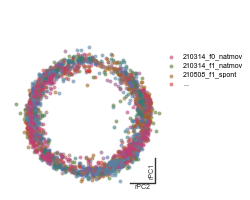

In [13]:
f, ax = plt.subplots(
    figsize=(2.5, 2.0), gridspec_kw=dict(bottom=0.05, left=0.0, top=0.8, right=0.7)
)

# Get unshuffled data:
pooled_data = pooled_df[pooled_df["group"] == "data"]

n_labels = 3
for i, fid in enumerate(pooled_data["exp_id"].unique()):
    sel_df = pooled_data[pooled_data["exp_id"] == fid]
    if i < n_labels:
        lab = fid
    elif i == n_labels:
        lab = "..."
    else:
        lab = "_nolegend_"

    plt.scatter(
        -sel_df["rpc2_proj"],
        sel_df["rpc1_proj"],
        s=8,
        color=COLS["fish_cols"][i],
        alpha=0.6,
        lw=0,
        label=lab,
    )
ax.legend(fontsize=5, labelspacing=0.3, bbox_to_anchor=(0.9, 0.95), loc=2)
pltltr.add_scalebar(
    ax,
    xlabel="rPC2",
    ylabel="rPC1",
    xpos=1.2,
    ypos=-1.2,
    xlen=-0.45,
    ylen=0.45,
    text_params=dict(fontsize=5),
    text_spacing_coef=0.03,
)
ax.axis("equal")
pltltr.savefig("all_fish_one_space.pdf")

Then, we look at the relationship between phase and anatomy:

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
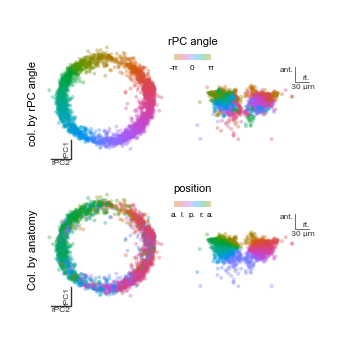

In [14]:
f, axs = plt.subplots(2, 2, figsize=(3.5, 3.5))
s = 8

# Get unshuffled data:
pooled_data = pooled_df[pooled_df["group"] == "data"]

labels = dict(rpc_angle="col. by rPC angle", anatomical_phase="Col. by anatomy")
alpha=0.35
for j, (color_by, col, lab, ticks, ticklabs) in enumerate(
    zip(
        ["rpc_angle", "anatomical_phase"],
        [COLS["phase"], COLS["phase"]],
        ["rPC angle", "position"],
        [
            [-np.pi + 0.01, 0, np.pi - 0.01],
            [-np.pi + 0.01, -np.pi / 2, 0, np.pi / 2, np.pi - 0.01],
        ],
        [["-π", "0", "π"], ["a.", "l.", "p.", "r.", "a."]],
    )
):
    sc = axs[j, 0].scatter(
        -pooled_data["rpc2_proj"],
        pooled_data["rpc1_proj"],
        lw=0,
        c=pooled_data[color_by],
        cmap=col,  # COLS["phase"],
        s=s,
        alpha=alpha,
    )
    axs[j, 0].set_ylabel(f"col. by {color_by}")

    # for j, color_by in enumerate(["rpc_angle", "anatomical_phase"]:
    axs[j, 1].scatter(
        pooled_data["lr_pos"],
        pooled_data["ap_pos"],
        lw=0,
        c=pooled_data[color_by],
        cmap=col,
        s=s,
        alpha=alpha,
    )
    axs[j, 0].set_ylabel(labels[color_by])

    pltltr.add_anatomy_scalebar(axs[j, 1], pos=(110, 40), length=30, fontsize=6)
    pltltr.despine(axs[j, 1], "all")
    pltltr.despine(axs[j, 0], "all")

    pltltr.add_scalebar(
        axs[j, 0],
        xlabel="rPC2",
        ylabel="rPC1",
        xpos=-0.8,
        xlen=-0.45,
        ylen=0.45,
        fontsize=6,
    )

    pltltr.add_cbar(
        sc,
        axs[j, 1],
        inset_loc=(-0.1, 0.9, 0.3, 0.05),
        ticks=ticks,
        ticklabels=ticklabs,
        title=lab,
        orientation="horizontal",
        titlesize=8,
        labelsize=6,
    )


pltltr.savefig("pooled_angles_all_fish")

In [15]:
n_rois = len(pooled_df[pooled_df["group"] == "data"])

# create the function we want to fit
def my_cos(x, amplitude, phase, offset, freq):
    return np.cos(x * freq + phase) * amplitude + offset


# Perform the fit.
# We will fit on the first half of the data, and then measure R^2 over the left outs:
initial_guesses = dict(lr_pos=(80, np.pi, 0, 1), ap_pos=(80, np.pi / 2, 0, 1))

fit_data_slice = slice(0, n_rois // 2)
test_slice = slice(n_rois // 2, None)

fit_results = []
for group in ["data", "shuf"]:
    group_data = pooled_df[pooled_df["group"] == group]

    for ax in ["lr_pos", "ap_pos"]:

        try:
            fit, _ = curve_fit(
                my_cos,
                group_data["rpc_angle"].values[fit_data_slice],
                group_data[ax].values[fit_data_slice],
                p0=initial_guesses[ax],
            )
        except RuntimeError:
            print(f"Runtime error encountered while fitting {group}")
            fit = list(initial_guesses[ax])
            fit[0] = 0

        fit_results.append(
            dict(group=group, ax=ax, amp=fit[0], ph=fit[1], off=fit[2], freq=fit[3],)
        )

fit_results = pd.DataFrame(fit_results)

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
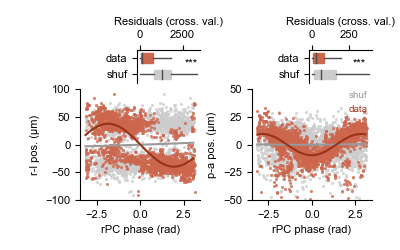

In [16]:
n_bins = 40
cols = [(0.8,) * 3, (0.8, 0.4, 0.3)]

ax_labels = dict(lr_pos="r-l pos. (μm)", ap_pos="p-a pos. (μm)")

fig = plt.figure(figsize=(4, 2.5))

gs = gridspec.GridSpec(
    4, 6, figure=fig, left=0.2, wspace=9, bottom=0.2, right=0.93, top=0.8
)
axs_scat = [fig.add_subplot(gs[1:, :3]), fig.add_subplot(gs[1:, 3:])]
axs_comp = [fig.add_subplot(gs[0, 1:3]), fig.add_subplot(gs[0, 4:])]

x_array = np.arange(-np.pi, np.pi, 0.1)

res = []

for j, ax in enumerate(["lr_pos", "ap_pos"]):
    residuals = []
    for i, group in enumerate(["shuf", "data"]):
        group_data = pooled_df[pooled_df["group"] == group]

        axs_scat[j].scatter(
            group_data["rpc_angle"],
            group_data[ax],
            color=cols[i],
            s=5,
            alpha=0.8,
            lw=0,
            label="_nolegend_",
        )

        fit_params = fit_results[
            (fit_results["group"] == group) & (fit_results["ax"] == ax)
        ]
        y = my_cos(x_array, *list(fit_params.iloc[0, 2:].values))
        axs_scat[j].plot(x_array, y, color=pltltr.dark_col(cols[i]), label=group)

        axs_scat[j].set(xlabel="rPC phase (rad)", ylabel=ax_labels[ax])
        pltltr.despine(axs_scat[j])

        group_data = pooled_df[pooled_df["group"] == group]

        predicted = my_cos(
            group_data["rpc_angle"].values[test_slice],
            *list(fit_params.iloc[0, 2:].values)
        )

        residuals.append((predicted - group_data[ax].values[test_slice]) ** 2)

    bpltr = pltltr.boxplot(
        residuals, cols=cols, ax=axs_comp[j], widths=0.6, ec=(0.3,) * 3
    )
    axs_comp[j].text(
        np.mean(bpltr["whiskers"][1].get_xdata()),
        1.5,
        pltltr.get_pval_stars(mannwhitneyu(*residuals)),
        fontsize=8,
    )
    axs_comp[j].set_yticklabels(["shuf", "data"])
    axs_comp[j].tick_params(axis="both", which="both", labelsize=8)
    axs_comp[j].xaxis.tick_top()
    axs_comp[j].xaxis.set_label_position("top")
    axs_comp[j].set_xlabel("Residuals (cross. val.)", fontsize=8)

    [axs_comp[j].axes.spines[s].set_visible(False) for s in ["bottom", "right"]]


axs_scat[0].set_ylim(-100, 100)
axs_scat[1].set_ylim(-50, 50)
axs_scat[1].legend(
    markerscale=1.5,
    handletextpad=-0.3,
    labelcolor="linecolor",
    handlelength=0.0,
    bbox_to_anchor=(0.755, 0.7),
    fontsize=7,
)

pltltr.savefig("fit_anatomical_distribution.pdf")

## Redefine network phase

Now that we have a standard alignment of phase across fish, we can redefine our network phase starting from the rPC angles, to ensure that for all fish:
 - network phase 0 -> rostral activation,
 - phase -pi/2 -> right activation, 
 - phase pi/2 -> left activation, 
 - phase pi/-pi -> back activation
 
Positive phase changes mean cw network activity rotation, anf negative phase changes ccw rotations.

In [17]:
exp = LotrExperiment(A_FISH)

# From out previous definition of network phase:
norm_activity = get_zero_mean_weights(exp.traces[:, exp.hdn_indexes].T).T
avg_vects = np.einsum("ij,ik->jk", norm_activity.T, exp.rpc_scores)

phase = np.arctan2(avg_vects[:, 1], -avg_vects[:, 0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
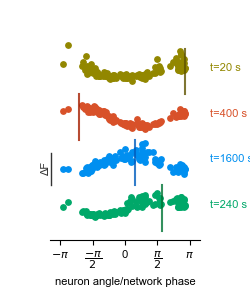

meta NOT subset; don't know how to subset; dropped


In [24]:
d = -7
f, ax = plt.subplots(figsize=(2.5, 3), gridspec_kw=dict(left=0.2, bottom=0.2, right=0.875))
for n, i in enumerate([100, 2000, 8000, 1200]):
    c = pltltr.get_default_phase_col(phase[i])
    ax.scatter(
        exp.rpc_angles, zscore(exp.traces[i, exp.hdn_indexes]) + n * d, color=c, s=15
    )
    ax.plot(
        [phase[i], phase[i]], np.array([-1, 1]) * (d / 2) + n * d, c=pltltr.dark_col(c)
    )
    ax.text(np.pi + 1, n * d, f"t={i//exp.fs} s", c=c)

pltltr.add_scalebar(
    ax, xlabel="", ylabel="ΔF", xlen=0, ypos=d * 2.5, disable_axis=False
)
pltltr.despine(ax, ["left", "right", "top"])
ax.set(
    xlabel="neuron angle/network phase",
    xlim=(-np.pi - 0.5, np.pi + 0.5),
    xticks=([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]),
    xticklabels=["$-π$", r"$\dfrac{-π}{2}$", 0, r"$\dfrac{π}{2}$", "$π$"],
)
plt.show()

pltltr.savefig("network_phases.pdf")

In the subsequent analyses, we will be using the `LotrExperiment.network_phase` property for this quantification.

In [19]:
assert np.allclose(phase, exp.network_phase, rtol=0.001)

## Individual neurons histograms

How does the activation profile of each neuron over phase of the network look like? That's what we compute here.

#TODO add arrows with men orientation

In [20]:
bin_n = 100
bins = np.linspace(-np.pi, np.pi, bin_n)

all_neurons_bins = np.zeros((bin_n - 1, exp.n_hdns))
sel_traces = exp.traces[:, exp.hdn_indexes]

for i in range(bin_n - 1):
    selection = (bins[i] < exp.network_phase) & (exp.network_phase < bins[i + 1])
    all_neurons_bins[i, :] = sel_traces[selection, :].mean(0)
    
vect_avgs = np.stack([np.cos(bins[:-1]), np.sin(bins[:-1])]) @ all_neurons_bins
angles = np.angle(vect_avgs[0, :] + 1j * vect_avgs[1, :])

### Plot with negative in separate lobe:

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
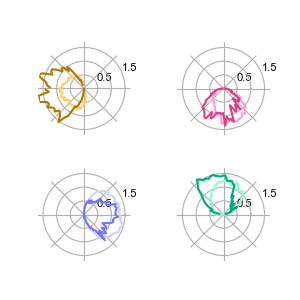

In [21]:
indexes = [82, 37, 101, 59]  # 19, 14, 64]
f, axs = plt.subplots(
    2,
    2,
    figsize=(3, 3),
    subplot_kw={"projection": "polar"},
    gridspec_kw=dict(wspace=0.5),
)

for n, i in enumerate(indexes):
    ax = axs[n // 2, n % 2]
    col = (
        pltltr.get_continuous_colors([angles[i]], COLS["phase"], vlims=[-np.pi, np.pi])
        / 255
    )
    t_pos, t_neg = [all_neurons_bins[:, i].copy() for _ in range(2)]
    t_pos[t_pos < 0] = np.nan
    t_neg[t_neg > 0] = np.nan
    ax.plot(
        (bins[1:] + bins[:-1]) / 2 + np.pi, -t_neg, c=pltltr.shift_lum(col, 0.4),
    )
    ax.plot(
        (bins[1:] + bins[:-1]) / 2, t_pos, c=col,
    )
    # ax.fill(
    #    (bins[1:] + bins[:-1]) / 2,
    #    all_neurons_bins[:, i],
    #    alpha=1, fc=col,lw=0)
    # plt.grid(False)
    ax.set(
        yticks=[0, 0.5, 1, 1.5],
        yticklabels=["", "0.5", "", "1.5"],
        ylim=[0, 1.7],
        xticklabels=[]
        # xticks=[0, np.pi / 2, np.pi, 3 / 2 * np.pi],
        # xticklabels=["0", "π/2", "π", "3π/2"],
    )
    ax.spines["polar"].set_visible(False)
pltltr.savefig("single neuron histograms_neg")

### Plot with single lobe:

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
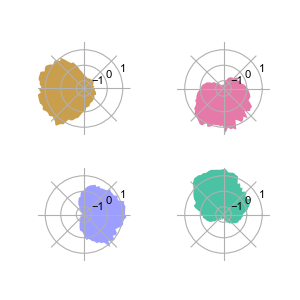

In [22]:
indexes = [82, 37, 101, 59]  # 19, 14, 64]
f, axs = plt.subplots(
    2,
    2,
    figsize=(3, 3),
    subplot_kw={"projection": "polar"},
    gridspec_kw=dict(wspace=0.5),
)

for n, i in enumerate(indexes):
    ax = axs[n // 2, n % 2]
    col = (
        pltltr.get_continuous_colors([angles[i]], COLS["phase"], vlims=[-np.pi, np.pi])
        / 255
    )
    ax.fill((bins[1:] + bins[:-1]) / 2, all_neurons_bins[:, i], alpha=0.7, fc=col, lw=0)
    # plt.grid(False)
    ax.set(
        yticks=[-1, 0, 1],
        # yticklabels=["", "0.5", "", "1.5"],
        ylim=[-1.5, 1.5],
        xticklabels=[]
        # xticks=[0, np.pi / 2, np.pi, 3 / 2 * np.pi],
        # xticklabels=["0", "π/2", "π", "3π/2"],
    )
    ax.spines["polar"].set_visible(False)
pltltr.savefig("single neuron histograms_shade")